# Zadatak 1
U timu predmeta na MSTeams platformi dostupna je baza slikanih šaka koje pokazuju „papir“, „kamen“ i „makaze“. 
Projektovati inovativni sistem za prepoznavanje pokazanih znakova zasnovan na testiranju hipoteza. 

a) Detaljno opisati algoritam za obradu slike i odabir obeležja koji prethodi samoj klasifikaciji. Algoritam treba da bude 
što robusniji (na različite osvetljaje, položaje šaka, načine pokazivanja znakova itd). 

b) Izvršiti podelu na trening i test skup. Rezultate klasifikacije test skupa prikazati u obliku matrice konfuzije. 

c) Odabrati dva znaka i dva obeležja takva da su odabrani znakovi što separabilniji u tom prostoru. Prikazati histogram 
obeležja za oba slova i prokomentarisati njihov oblik. 

d) Za slova i obeležja pod c) projektovati parametarski klasifikator po izboru i iscrtati klasifikacionu liniju. 

## a)

### Preprocesiranje slike

Za prepoznavanje znakova rukom (papir, kamen, makaze) na slikama sa zelenom pozadinom, potrebno je izvršiti niz koraka preprocesiranja kako bi se od originalne slike dobila binarna maska koja jasno izdvaja šaku.

Funkcija izoluj_saku kao ulaz prima putanju do slike, a vraća izdvojenu binarnu sliku šake.

Slika se prvo učitava u RGB formatu, a zatim se konvertuje u HSV (hue, saturation, value) format. Ovaj format je pogodniji za segmentaciju boja jer omogućava da se boje razdvoje nezavisno od osvetljenja i senki.  

Pozadina slike je zelena, pa se definiše opseg nijansi zelene boje u HSV prostoru - donja_granica i gornja_granica. U tom opsegu izdvajaju se pikseli pozadine.

Određivanjem piksela koji nisu u definisanom opsegu zelene boje dobijamo masku šake. Saka ce biti bele boje, dok ce pozadina biti crna. Dobijena slika predstavlja binarnu (crno-belu sliku).

Radi bolje obrade, uklanja se po 5 piksela sa gornje, donje i leve ivice slike. Ovim se eliminišu potencijalno loše oblasti na granicama. Ne uzimamo i desnu ivicu zato sto se cesto tu nalazi šaka.

Da bi se popunile praznine i otklonile nepravilnosti u konturi, koristi se zatvaranje slike (closing):  
- dilatacija popunjava rupe u segmentisanim delovima  
- erozija nakon toga vraća konturu u granice sličnim početnim (istanjuje ono što je dilatacija podebljala)  

Na dobijenu sliku primenjuje se median filter sa maskom $7 \times 7$. Na ovaj način se uklanja „salt & pepper“ šum koji se može javiti u procesu segmentacije.


Kao poslednji korak, slika se kropuje tako da ostane samo deo gde se nalazi šaka. Leva granica se pomera nadesno dok ne naiđe na kolonu sa belim pikselima. Sličan posao obavljam za ostale ivice.

Na ovaj način se dobija kropova binarna slika šake, koju ću koristiti za klasifikaciju.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.stats import mode
from skimage import io, color, morphology, filters
import os

In [28]:
def izoluj_saku(putanja_slike):
    
    img = io.imread(putanja_slike)
    hsv = color.rgb2hsv(img)
    donja_zelena = np.array([85/360, 0.2, 0.2]) 
    gornja_zelena = np.array([170/360, 1.0, 1.0])
    
    maska_pozadine = (
        (hsv[..., 0] >= donja_zelena[0]) & (hsv[..., 0] <= gornja_zelena[0]) &
        (hsv[..., 1] >= donja_zelena[1]) & (hsv[..., 1] <= gornja_zelena[1]) &
        (hsv[..., 2] >= donja_zelena[2]) & (hsv[..., 2] <= gornja_zelena[2])
    )
    
    maska_sake = ~maska_pozadine
    
    binarna = np.where(maska_sake, 255, 0).astype(np.uint8)
    binarna = binarna[5:binarna.shape[0]-5, 5:]
    
    dilatacija = morphology.dilation(binarna, morphology.disk(2))
    erozija = morphology.erosion(dilatacija, morphology.disk(2))

    zatvaranje = erozija.astype(np.uint8) * 255
    
    filtrirana = filters.median(zatvaranje, np.ones((7, 7), dtype=np.uint8)) * 255
    
    M,N = np.shape(filtrirana)

    left = 0
    while(left < N-1 and np.sum(filtrirana[:, left] == 255) == 0):
        left += 1
    
    right = N-1
    while(right > 0 and np.sum(filtrirana[:, right] == 255) == 0):
        right -= 1
    
    up = 0
    while(up < M-1 and np.sum(filtrirana[up, :] == 255) == 0):
        up += 1
    
    down = M-1
    while(down > 0 and np.sum(filtrirana[down, :] == 255) == 0):
        down -= 1

    kropovana = filtrirana[up:down, left:right]

    return kropovana

In [ ]:
rock_processed = [] 
scissors_processed = []
paper_processed = []

path = r'E:\SEDMI SEMESTAR\PO'
folder_path = os.path.join(path, 'RPS')
folder_paper = os.path.join(folder_path,'paper')
folder_rock = os.path.join(folder_path,'rock')
folder_scissors = os.path.join(folder_path,'scissors')

for filename in os.listdir(folder_scissors):
    image_path = os.path.join(folder_scissors, filename)
    scissors_processed.append(izoluj_saku(image_path))

for filename in os.listdir(folder_rock):
    image_path = os.path.join(folder_rock, filename)
    rock_processed.append(izoluj_saku(image_path))
    
for filename in os.listdir(folder_paper):
    image_path = os.path.join(folder_paper, filename)
    paper_processed.append(izoluj_saku(image_path))

#### Primer

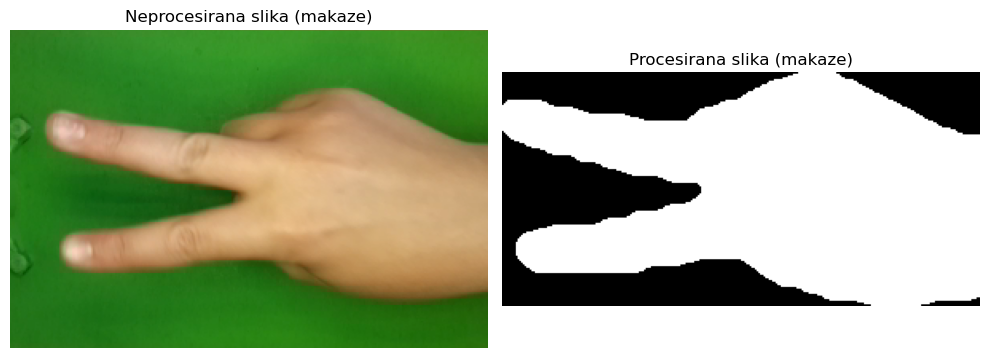

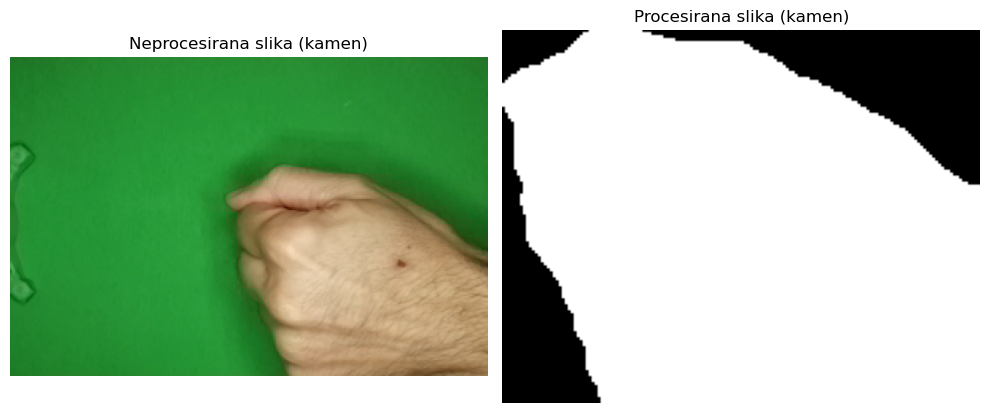

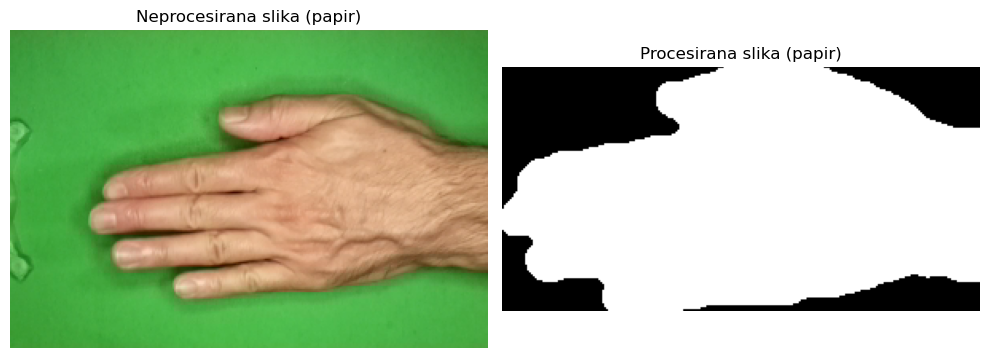

In [29]:
image_path = os.path.join(folder_scissors, os.listdir(folder_scissors)[2])
image = izoluj_saku(image_path)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(io.imread(image_path))
ax[0].set_title("Neprocesirana slika (makaze)")
ax[0].axis("off")

ax[1].imshow(image, cmap='gray')
ax[1].set_title("Procesirana slika (makaze)")
ax[1].axis("off")

plt.tight_layout()
plt.show()


image_path = os.path.join(folder_rock, os.listdir(folder_rock)[2])
image = izoluj_saku(image_path)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(io.imread(image_path))
ax[0].set_title("Neprocesirana slika (kamen)")
ax[0].axis("off")

ax[1].imshow(image, cmap='gray')
ax[1].set_title("Procesirana slika (kamen)")
ax[1].axis("off")

plt.tight_layout()
plt.show()


image_path = os.path.join(folder_paper, os.listdir(folder_paper)[0])
image = izoluj_saku(image_path)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(io.imread(image_path))
ax[0].set_title("Neprocesirana slika (papir)")
ax[0].axis("off")

ax[1].imshow(image, cmap='gray')
ax[1].set_title("Procesirana slika (papir)")
ax[1].axis("off")

plt.tight_layout()
plt.show()

### Atributi

Za atribute sam uzela udeo belih piksela u levom delu slike, tj. gledala sam od šestine do trećine slike i u tom delu sračunala udeo belih piksela. Očekujem da makaze imaju najmanji udeo, dok bi kamen trebalo da ima najveći udeo, a papir će biti negde u sredini.

Za drugi atribut je sračunat centar šake, očekujem da kamen ima najveće vrednosti - jer je relativno centrirana šaka, dok preostale dve bi trebalo da imaju nešto manje vrednosti, jer je kod njih šaka ispružena (izduženija, nije u centru).

In [3]:
def udeo_belih(image):
    sirina = image.shape[1]
    
    start = int(np.floor(sirina / 6))
    stop = int(np.floor(sirina / 3))
    
    levi_deo = image[:, start:stop]
    
    beli_pikseli = np.sum(levi_deo == 255)
    ukupno_pikseli = levi_deo.size
    
    return beli_pikseli / ukupno_pikseli

In [9]:
def nadji_centar(image):
    rows, cols = np.where(image == 255)
    
    r = int(np.mean(rows))
    c = int(np.mean(cols))
    
    return r, c

In [10]:
def izdvoj_atribute(images):
    atributi = np.zeros((2, len(images)))
    
    for i, image in enumerate(images):
        atributi[0, i] = udeo_belih(image)
        r, c = nadji_centar(image)
        atributi[1, i] = r/c
    
    return atributi

## b)

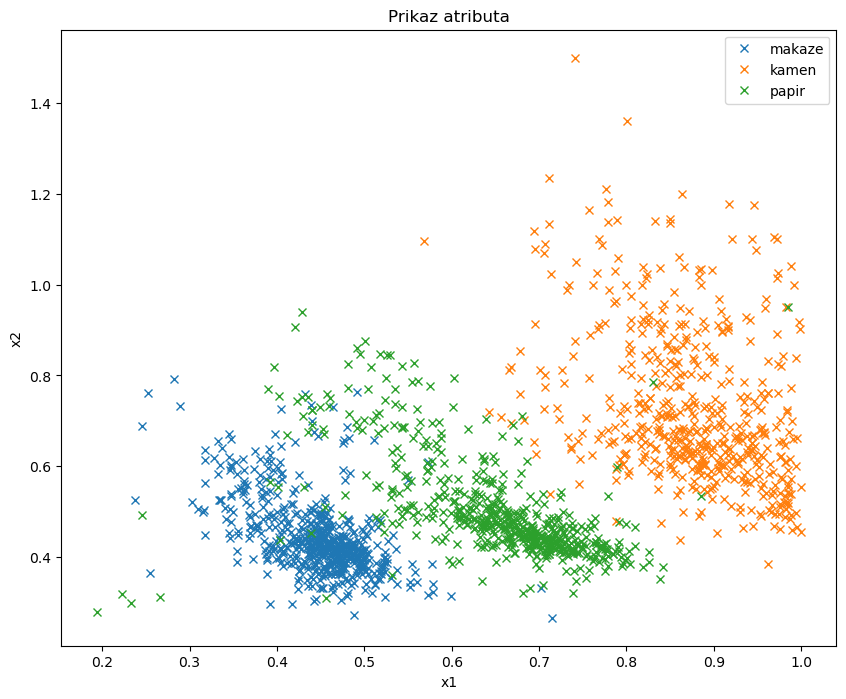

In [38]:
features_paper = izdvoj_atribute(paper_processed)
features_rock = izdvoj_atribute(rock_processed)
features_scissors = izdvoj_atribute(scissors_processed)

s_dim = features_scissors.shape[1]
r_dim = features_rock.shape[1]

X = np.concatenate((features_scissors, features_rock, features_paper), axis=1)
Y = np.ones((X.shape[1]))
Y[s_dim:s_dim+r_dim] = 2
Y[s_dim+r_dim:] = 3

X_train, X_test, Y_train, Y_test = train_test_split(X.T, Y, test_size=0.2, stratify=Y, random_state=25)
X_train = X_train.T
X_test = X_test.T
X1 = X_train[:,Y_train==1]
X2 = X_train[:,Y_train==2]
X3 = X_train[:,Y_train==3]

plt.figure(figsize=(10,8))
plt.plot(X1[0,:], X1[1,:], 'x')
plt.plot(X2[0,:], X2[1,:], 'x')
plt.plot(X3[0,:], X3[1,:], 'x')
plt.legend(['makaze', 'kamen', 'papir'])
plt.title('Prikaz atributa')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [42]:
M1 = np.mean(X1, axis=1, keepdims=True)
M2 = np.mean(X2, axis=1, keepdims=True)
M3 = np.mean(X3, axis=1, keepdims=True)

S1 = np.cov(X1)
S2 = np.cov(X2)
S3 = np.cov(X3)

In [48]:
def gaussian_pdf(X, M, S):
    detS = np.linalg.det(S)
    invS = np.linalg.inv(S)
    n = S.shape[1]
    f = 1/(2*np.pi*detS**0.5)*np.exp(-0.5*(X-M).T@invS@(X-M))
    return f[0,0]


def plot_cm(Y, Y_pred, skup="trening"):
    cm = confusion_matrix(Y, Y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d")

    plt.xlabel("Predikcija")
    plt.ylabel("Istina")
    plt.title(f"Konfuziona matrica za {skup} skup")
    plt.show()
    
    
def predict(X, M_list, S_list):
    Y_pred = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        odb = X[:, i].reshape(-1, 1)
        fs = []
        for M, S in zip(M_list, S_list):
            fs.append(gaussian_pdf(odb, M, S))
        Y_pred[i] = np.argmax(fs) + 1
    return Y_pred

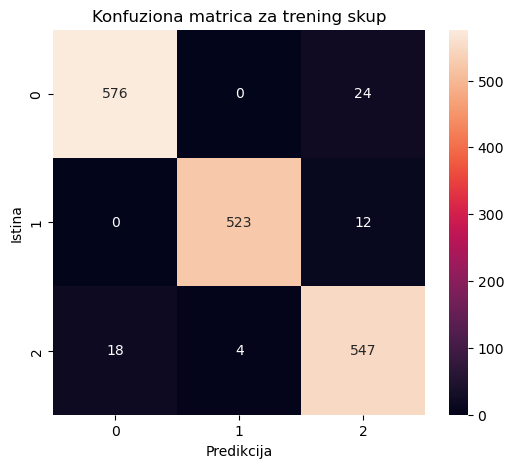

In [49]:
Y_train_pred = predict(X_train, [M1, M2, M3], [S1, S2, S3])
plot_cm(Y_train, Y_train_pred)

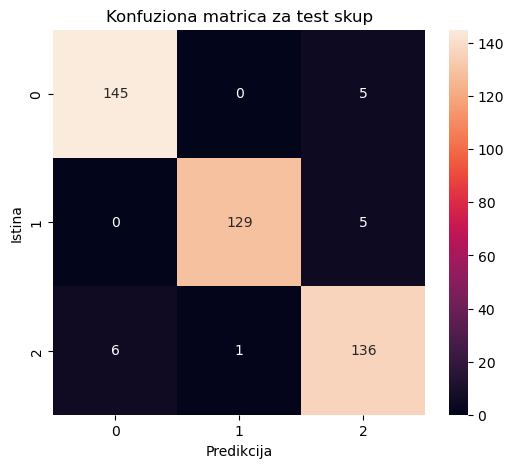

In [50]:
Y_test_pred = predict(X_test, [M1, M2, M3], [S1, S2, S3])
plot_cm(Y_test, Y_test_pred, 'test')

Dobija se visok procenat tačnosti i na 3 klase koristeći samo 2 atributa

### c)
Očigledno je da su kamen i makaze najrazdvojeniji tako da sam se odlučila da klasifikujem ta dva znaka. Pošto su linarno separabilni, najlakše je projektovati linearni klasifikator.

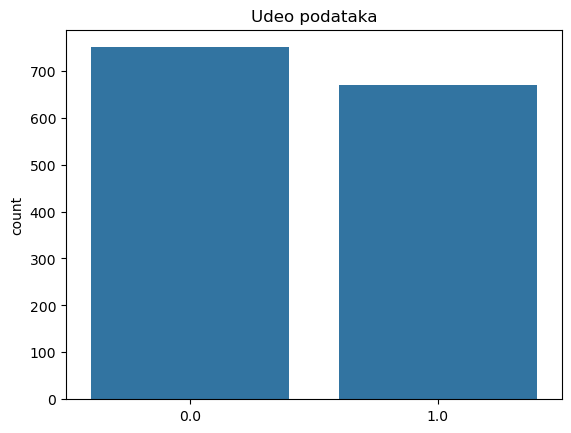

In [53]:
X = np.concatenate((features_scissors, features_rock), axis=1)
Y = np.zeros((X.shape[1]))
Y[features_s.shape[1]:] = 1

plt.figure()
sns.countplot(x=Y)
plt.title('Udeo podataka')
plt.show()

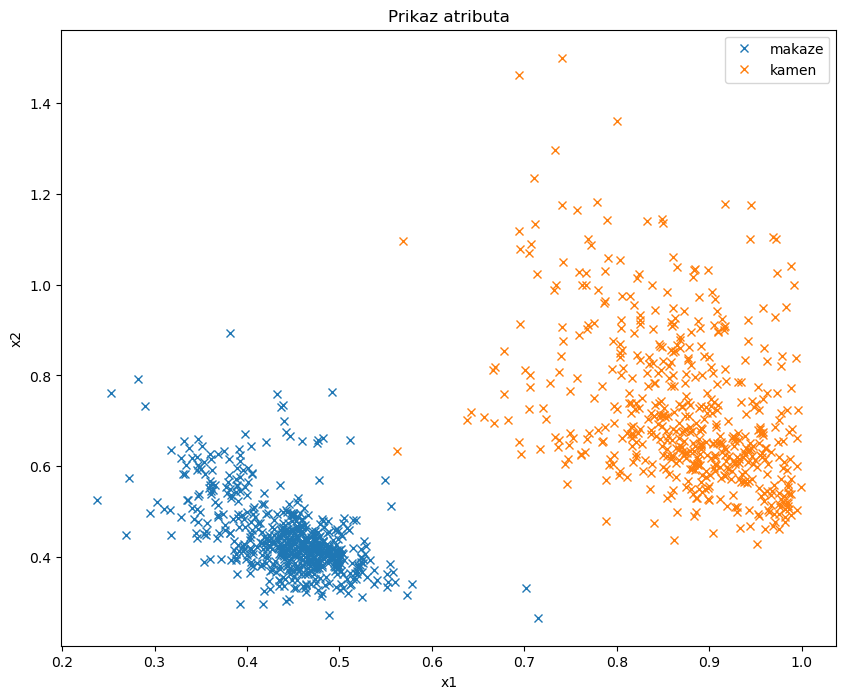

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(X.T, Y, test_size=0.2, stratify=Y, random_state=42)
X_train = X_train.T
X_test = X_test.T
X1 = X_train[:,Y_train==0]
X2 = X_train[:,Y_train==1]

plt.figure(figsize=(10,8))
plt.plot(X1[0,:], X1[1,:], 'x')
plt.plot(X2[0,:], X2[1,:], 'x')
plt.legend(['makaze', 'kamen'])
plt.title('Prikaz atributa')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

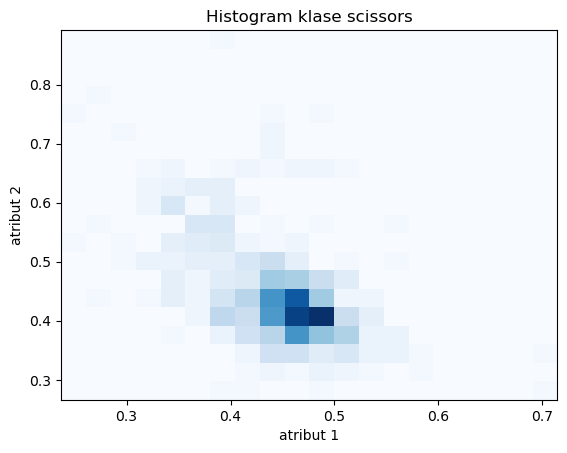

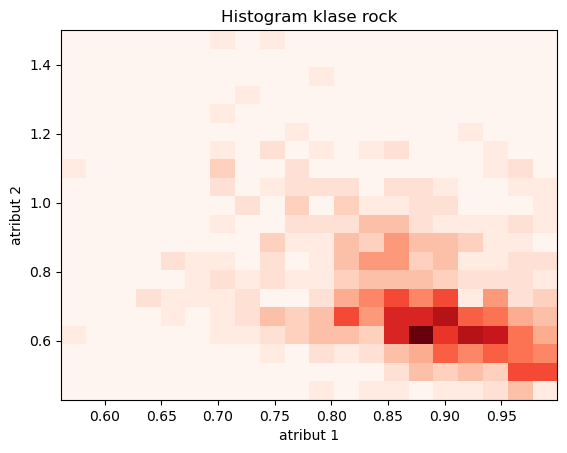

In [56]:
plt.figure()
plt.hist2d(X1[0,:], X1[1,:], bins=20, alpha=1, cmap='Blues')
plt.title('Histogram klase scissors')
plt.xlabel('atribut 1')
plt.ylabel('atribut 2')
plt.show()

plt.figure()
plt.hist2d(X2[0,:], X2[1,:], bins=20, alpha=1, cmap='Reds')
plt.title('Histogram klase rock')
plt.xlabel('atribut 1')
plt.ylabel('atribut 2')
plt.show()

Uočavamo da su centroidi značajno udaljeni

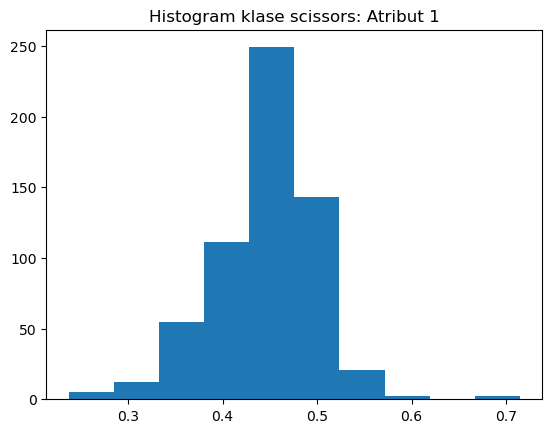

In [18]:
plt.hist(X1[0,:])
plt.title('Histogram klase scissors: Atribut 1')
plt.show()

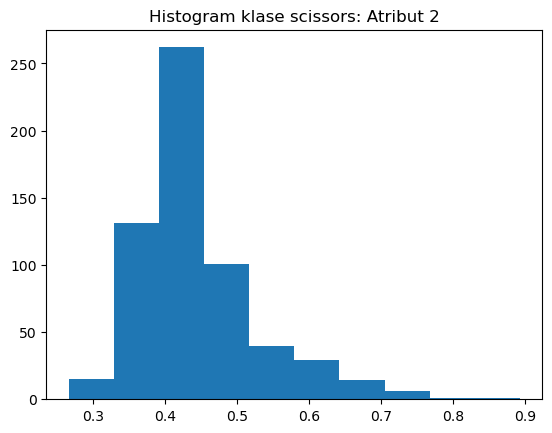

In [19]:
plt.hist(X1[1,:])
plt.title('Histogram klase scissors: Atribut 2')
plt.show()

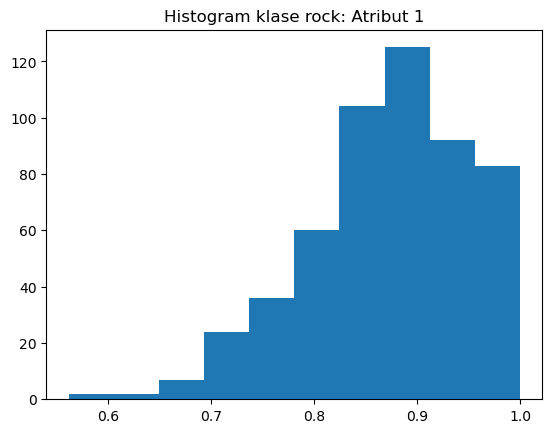

In [20]:
plt.hist(X2[0,:])
plt.title('Histogram klase rock: Atribut 1')
plt.show()

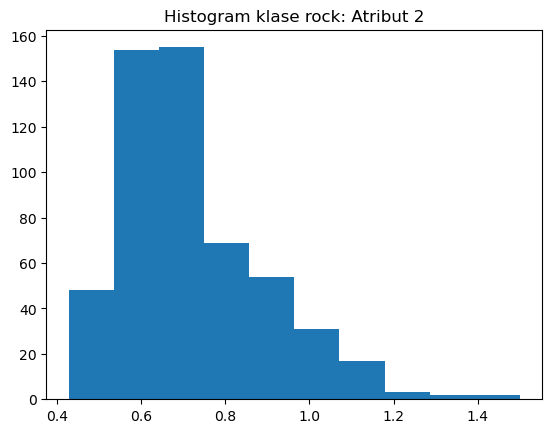

In [21]:
plt.hist(X2[1,:])
plt.title('Histogram klase rock: Atribut 2')
plt.show()

In [57]:
def druga_num_metoda(X1, X2):
    N1 = X1.shape[1]
    N2 = X2.shape[1]
    
    M1_est = np.mean(X1, axis=1).reshape(-1,1)
    M2_est = np.mean(X2, axis=1).reshape(-1,1)
    S1_est = np.cov(X1)
    S2_est = np.cov(X2)    
    
    s = np.arange(0,1,10**-3)
    v0_opt_s = []
    Neps_s = []
    
    for i in range(len(s)):
        V = np.linalg.inv(s[i]*S1_est + (1-s[i])*S2_est)@(M2_est-M1_est)
        Y1 = V.T@X1
        Y2 = V.T@X2
        Y = np.sort(np.concatenate((Y1, Y2), axis=1)) 
        v0 = np.zeros(Y.shape[1]-1) 
        Neps = np.zeros(Y.shape[1]-1)
        for j in range(Y.shape[1]-1):
            v0[j] = -(Y[0,j]+Y[0,j+1])/2
            Neps[j] += np.sum(Y1>-v0[j])
            Neps[j] += np.sum(Y2<-v0[j])  
        Neps_s.append(np.min(Neps))
        v0_opt_s.append(v0[np.argmin(Neps)])
    Neps_opt = min(Neps_s)
    v0_opt = v0_opt_s[np.argmin(Neps_s)]
    s_opt = s[np.argmin(Neps_s)]
    return (s_opt, v0_opt, Neps_opt, M1_est, M2_est, S1_est, S2_est)

In [58]:
s_opt, v0_opt, Neps_opt, M1_est, M2_est, S1_est, S2_est = druga_num_metoda(X1, X2)
V = np.linalg.inv(s_opt*S1_est + (1-s_opt)*S2_est)@(M2_est-M1_est)
v0 = v0_opt

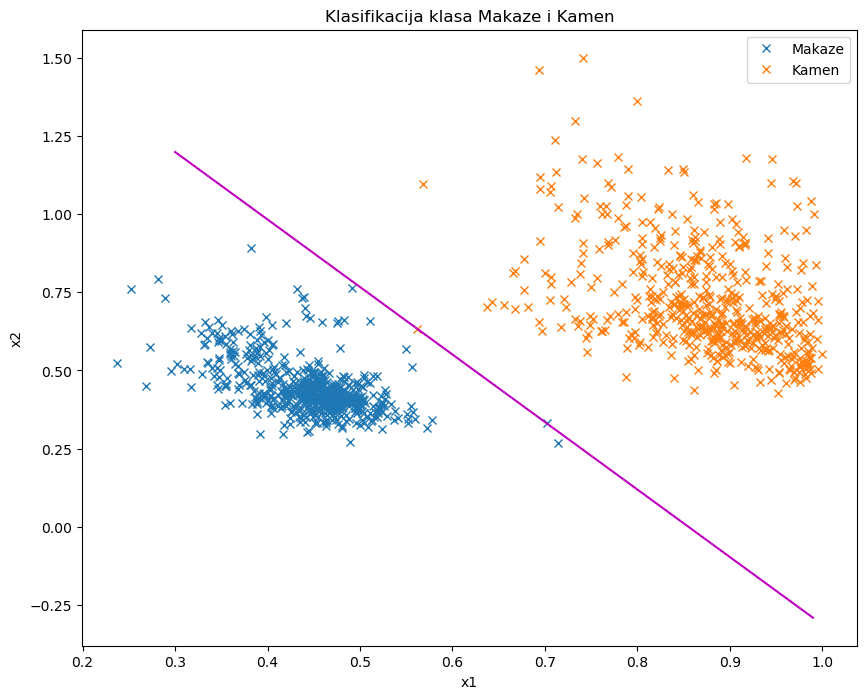

In [59]:
x1 = np.arange(0.3,1,0.01)
x2 = -(v0+V[0]*x1)/V[1]

plt.figure(figsize=(10, 8))
plt.plot(X1[0,:],X1[1,:], 'x')
plt.plot(X2[0,:],X2[1,:], 'x')
plt.plot(x1,x2,'m')
plt.title('Klasifikacija klasa Makaze i Kamen')
plt.legend(['Makaze', 'Kamen'])
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

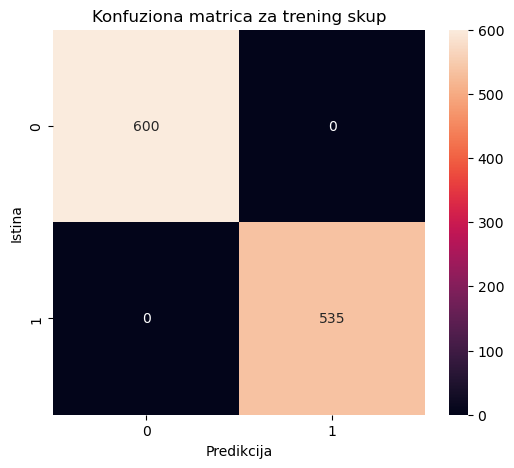

In [61]:
Y_pred = (V.T@X_train+v0)
Y_pred = Y_pred.reshape(-1,)
Y_pred[Y_pred>=0] = 1
Y_pred[Y_pred<0] = 0

plot_cm(Y_train, Y_pred)

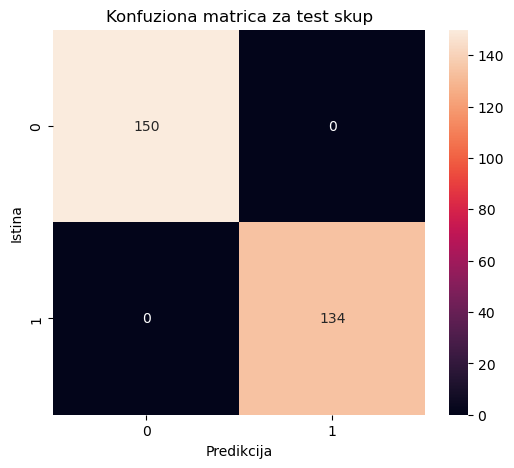

In [62]:
Y_pred = (V.T@X_test+v0)
Y_pred = Y_pred.reshape(-1,)
Y_pred[Y_pred>=0] = 1
Y_pred[Y_pred<0] = 0

plot_cm(Y_test, Y_pred, 'test')

Dobijamo tačost od 100% na oba skupa - linearno separabilni, pa linearni klasifikator odrađuje dobar posao. 